In [4]:
import numpy as np
import pypulseq as pp
import MRzeroCore as mr0
import torch
import matplotlib.pyplot as plt

# HACK: newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float

experiment_id = "flash"

# Pulseq and MRzeroCore

MRzero Core has functionality to parse and simulate pulseq .seq files.
We build the same pulseq sequence as before, but this time with pulseq.

In [5]:
sys = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6, adc_dead_time=20e-6,
    grad_raster_time=50e-6
)

In [6]:
n_read = 64
n_phase = 64
#  We ignore the slice selection gradients so this makes no difference
slice_thickness = 8e-3

rf = pp.make_sinc_pulse(
    flip_angle=5 * np.pi/180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=sys, return_gz=False
)
# Readout gradient
gx = pp.make_trapezoid('x', flat_area=n_read, flat_time=10e-3, system=sys)
adc = pp.make_adc(
    num_samples=n_read, duration=10e-3, delay=gx.rise_time,
    system=sys
)
# Rewinder before gx and spoiler afterwards
gx_pre = pp.make_trapezoid('x', area=-0.5*gx.area, duration=5e-3, system=sys)
gx_spoil = pp.make_trapezoid('x', area=1.5*gx.area, duration=2e-3, system=sys)

# Construct the sequence
seq = pp.Sequence()
for i in range(-n_phase//2, n_phase//2):
    # RF phase spoiling
    rf.phase_offset = (0.5 * (i**2+i+2) * 117) % 360 * np.pi / 180
    adc.phase_offset = rf.phase_offset
    seq.add_block(rf)
    # Phase encoding
    gy = pp.make_trapezoid('y', area=i, duration=5e-3, system=sys)
    seq.add_block(gx_pre, gy)
    seq.add_block(adc, gx)
    # Rewind phase and spoil
    gy = pp.make_trapezoid('y', area=-i, duration=5e-3, system=sys)
    seq.add_block(gx_spoil, gy)

    seq.add_block(pp.make_delay(1e-3))

Timing check passed successfully


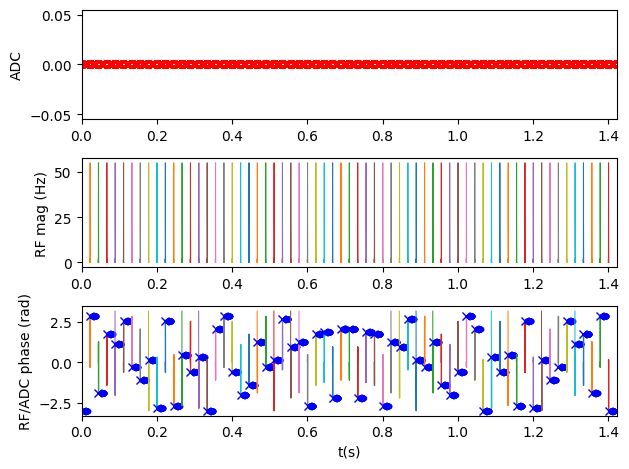

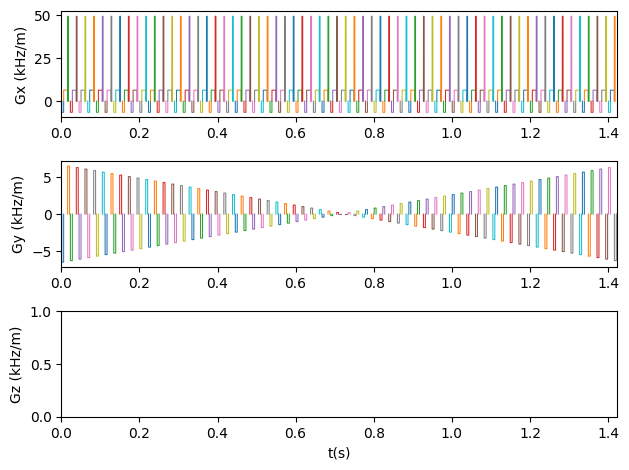

In [8]:
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed:")
    [print(e) for e in error_report]

seq.plot()

# The way we defined our sequence, it has a FOV of 1m
fov = 1
seq.set_definition("FOV", [fov, fov, slice_thickness])
seq.set_definition("Name", experiment_id)
seq.write("out/external.seq")
seq.write(f"out/{experiment_id}.seq")

VoxelGridPhantom
FOV: base * rel = tensor([0.1920, 0.1920, 0.1920]) * tensor([1., 1., 1.]) = tensor([0.1920, 0.1920, 0.1920])


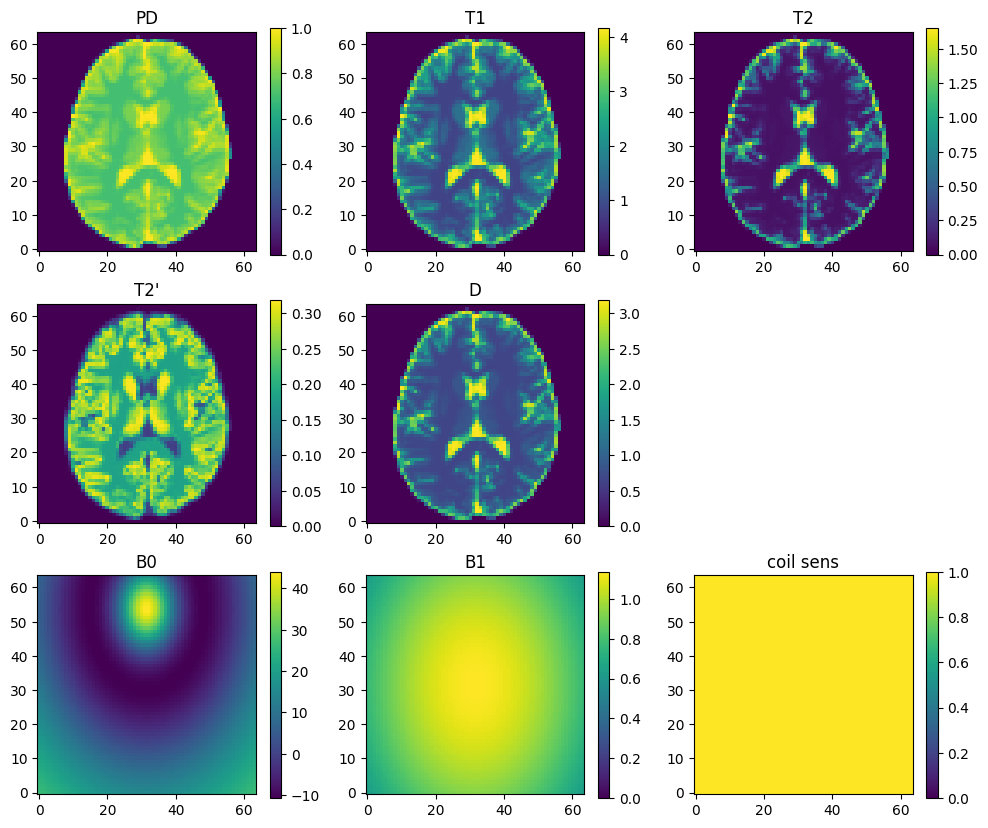

c:\Users\jonat\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\jonat\AppData\Local\Programs\Python\Python311\Lib\site-packages\MRzeroCore\phantom\voxel_grid_phantom.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2,


In [9]:
phantom = mr0.VoxelGridPhantom.brainweb("subject05.npz")
phantom = phantom.interpolate(64, 64, 32).slices([16])
phantom.plot()
data = phantom.build()

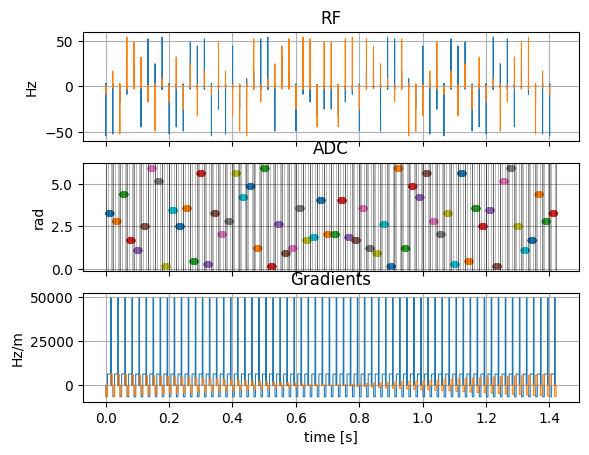

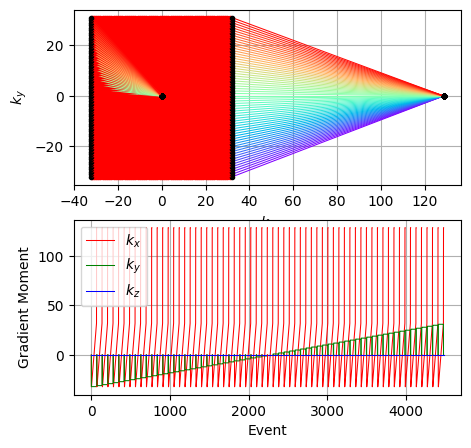

Calculating repetition 64 / 64 - done


In [10]:
seq_file = mr0.PulseqFile("out/external.seq")
seq_file.plot()

seq = mr0.Sequence.from_seq_file(seq_file)
seq.plot_kspace_trajectory()

graph = mr0.compute_graph(seq, data, 200, 1e-3)
signal = mr0.execute_graph(graph, seq, data)

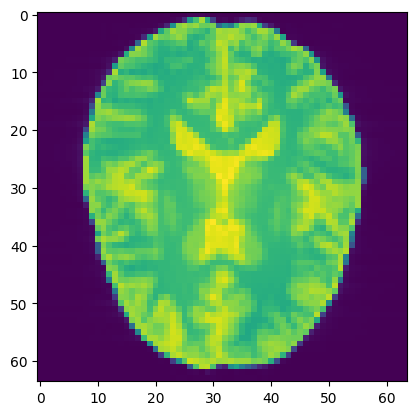

In [11]:
kspace = signal.view(n_phase, n_read)
reco = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fftshift(kspace)))

plt.figure()
plt.imshow(reco.abs())
plt.show()